### Algoritmos de aprendizado de máquina

DR Visão geral de algoritmos fundamentais de classificação e aprendizado de regressão. Aprender
quando você deve usar cada um e qual pré-processamento de dados é necessário. Cada algoritmo é
apresentado junto com um exemplo feito no scikit-learn.

Este guia explora diferentes algoritmos de aprendizagem supervisionada⁷⁰, classificados por complexidade crescente
(medido pelo número de parâmetros do modelo e hiperparâmetros). Eu sugeriria fortemente você começa com os mais simples ao trabalhar em um novo projeto/problema.

Mas por que não usar redes neurais profundas para tudo? Você pode, e talvez devesse. Mas a simplicidade pode percorrer um longo caminho antes da necessidade de aumentar a complexidade do seu projeto. Isso é
também é inteiramente possível não conseguir ajustar sua rede neural para vencer alguns dos algoritmos descritos aqui.

Você aprenderá sobre:
- Regressão linear
- Regressão Logística
- k-vizinhos mais próximos
- Baías ingénuas
- Árvores de decisão
- Máquinas de vetores de suporte

### O que constitui um algoritmo de aprendizagem?

Em sua essência, os algoritmos de aprendizado de máquina supervisionado aprendem uma função de mapeamento f que mapeia o
recursos de dados X para rótulos y. O objetivo é tornar o mapeamento o mais preciso possível. Podemos definir
o problema como: y = f(X) + e

onde e é um erro irredutível. Esse erro é independente dos dados e não pode ser reduzido usando o
dados (daí o nome).

O problema de encontrar a função f é notoriamente difícil. Na prática, você se contentará com um
boa aproximação. Existem muitas maneiras de realizar o trabalho. O que eles têm em comum?

### Componentes de um algoritmo de aprendizagem

- Funções de perda
- Otimizador que tenta minimizar a função de perda

A função de perda⁷³ gera um valor numérico que mostra o quão “ruins” são as previsões do seu modelo.
Quanto mais próximo o valor estiver de 0, melhores serão as previsões.

O trabalho do otimizador é encontrar os melhores valores possíveis para os parâmetros do modelo que minimizem o
função de perda. Isso é feito com a ajuda dos dados de treinamento e de um algoritmo que procura o
valores de parâmetros.

Gradient Descent⁷⁴ é o algoritmo mais comumente usado para otimização. Encontra um mínimo local
de uma função começando em um ponto aleatório e dando passos em uma direção e tamanho dados pelo
gradiente.

### Nossos dados

Usaremos o Auto Data Set⁷⁵ para criar exemplos para vários algoritmos de classificação e regressão.

Quilometragem, potência e outras informações para 392 veículos. Este conjunto de dados foi obtido
da biblioteca StatLib que é mantida na Carnegie Mellon University. O conjunto de dados
foi usado na Exposição da American Statistical Association de 1983.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import joblib

import warnings 
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 20, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
auto_df = pd.read_csv("data/auto.csv", index_col=0)
auto_df.shape

Temos 392 veículos e usaremos este subconjunto de recursos:

- mpg - milhas por galão
- cavalos de potência - Potência do motor
- peso - Peso do veículo (lbs.)
- aceleração - Tempo para acelerar de 0 a 60 mph (seg.)
- origem - Origem do carro (1. Americano, 2. Europeu, 3. Japonês)

Não temos dados faltantes.

#### Pré-processamento de dados

Vamos definir duas funções auxiliares que preparam uma classificação e um conjunto de dados de regressão com base
em nossos dados. Mas primeiro, vamos adicionar um novo recurso que especifica se um carro é de fabricação americana.
ou não:

In [ ]:
auto_df['is_american'] = (auto_df.origin == 1).astype(int)

Usaremos o StandarScaler⁷⁶ para dimensionar nossos conjuntos de dados:

In [ ]:
from sklearn.preprocessing import StandardScaler

def create_regression_dataset(df,
                              columns=['mpg', 'weight', 'horsepower']):

    all_columns = columns.copy()
    all_columns.append('acceleration')

    reg_df = df[all_columns]
    reg_df = StandardScaler().fit_transform(reg_df[all_columns])
    reg_df = pd.DataFrame(reg_df, columns=all_columns)

    return reg_df[columns], reg_df.acceleration

def create_classification_dataset(df):

    columns = ['mpg', 'weight', 'horsepower']
    X = df[columns]
    X = StandardScaler().fit_transform(X)
    X = pd.DataFrame(X, columns=columns)

    return X, df.is_american

#### Avaliação

Usaremos validação cruzada k-fold⁷⁷ para avaliar o desempenho de nossos modelos. Observe que isso
O guia NÃO está avaliando o desempenho do modelo. Aqui estão as definições de nossas funções de avaliação:

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

def eval_model(model, X, y, score):
    cv = KFold(n_splits=10, random_state=RANDOM_SEED)
    results = cross_val_score(model, X, y, cv=cv, scoring=score)
    return np.abs(results.mean())

def eval_classifier(model, X, y):
    return eval_model(model, X, y, score="accuracy")

def eval_regressor(model, X, y):
    return eval_model(model, X, y, score="neg_mean_squared_error")

Estamos usando a precisão (porcentagem de exemplos previstos corretamente) como métrica para nossa classificação
exemplos e erro quadrático médio (explicado abaixo) para os exemplos de regressão.

### Regressão linear

A regressão linear⁷⁸ tenta construir uma linha que melhor descreva a relação entre duas variáveis
X e Y. Essa linha é chamada de “melhor ajuste” e está mais próxima dos pontos (xi; yi).

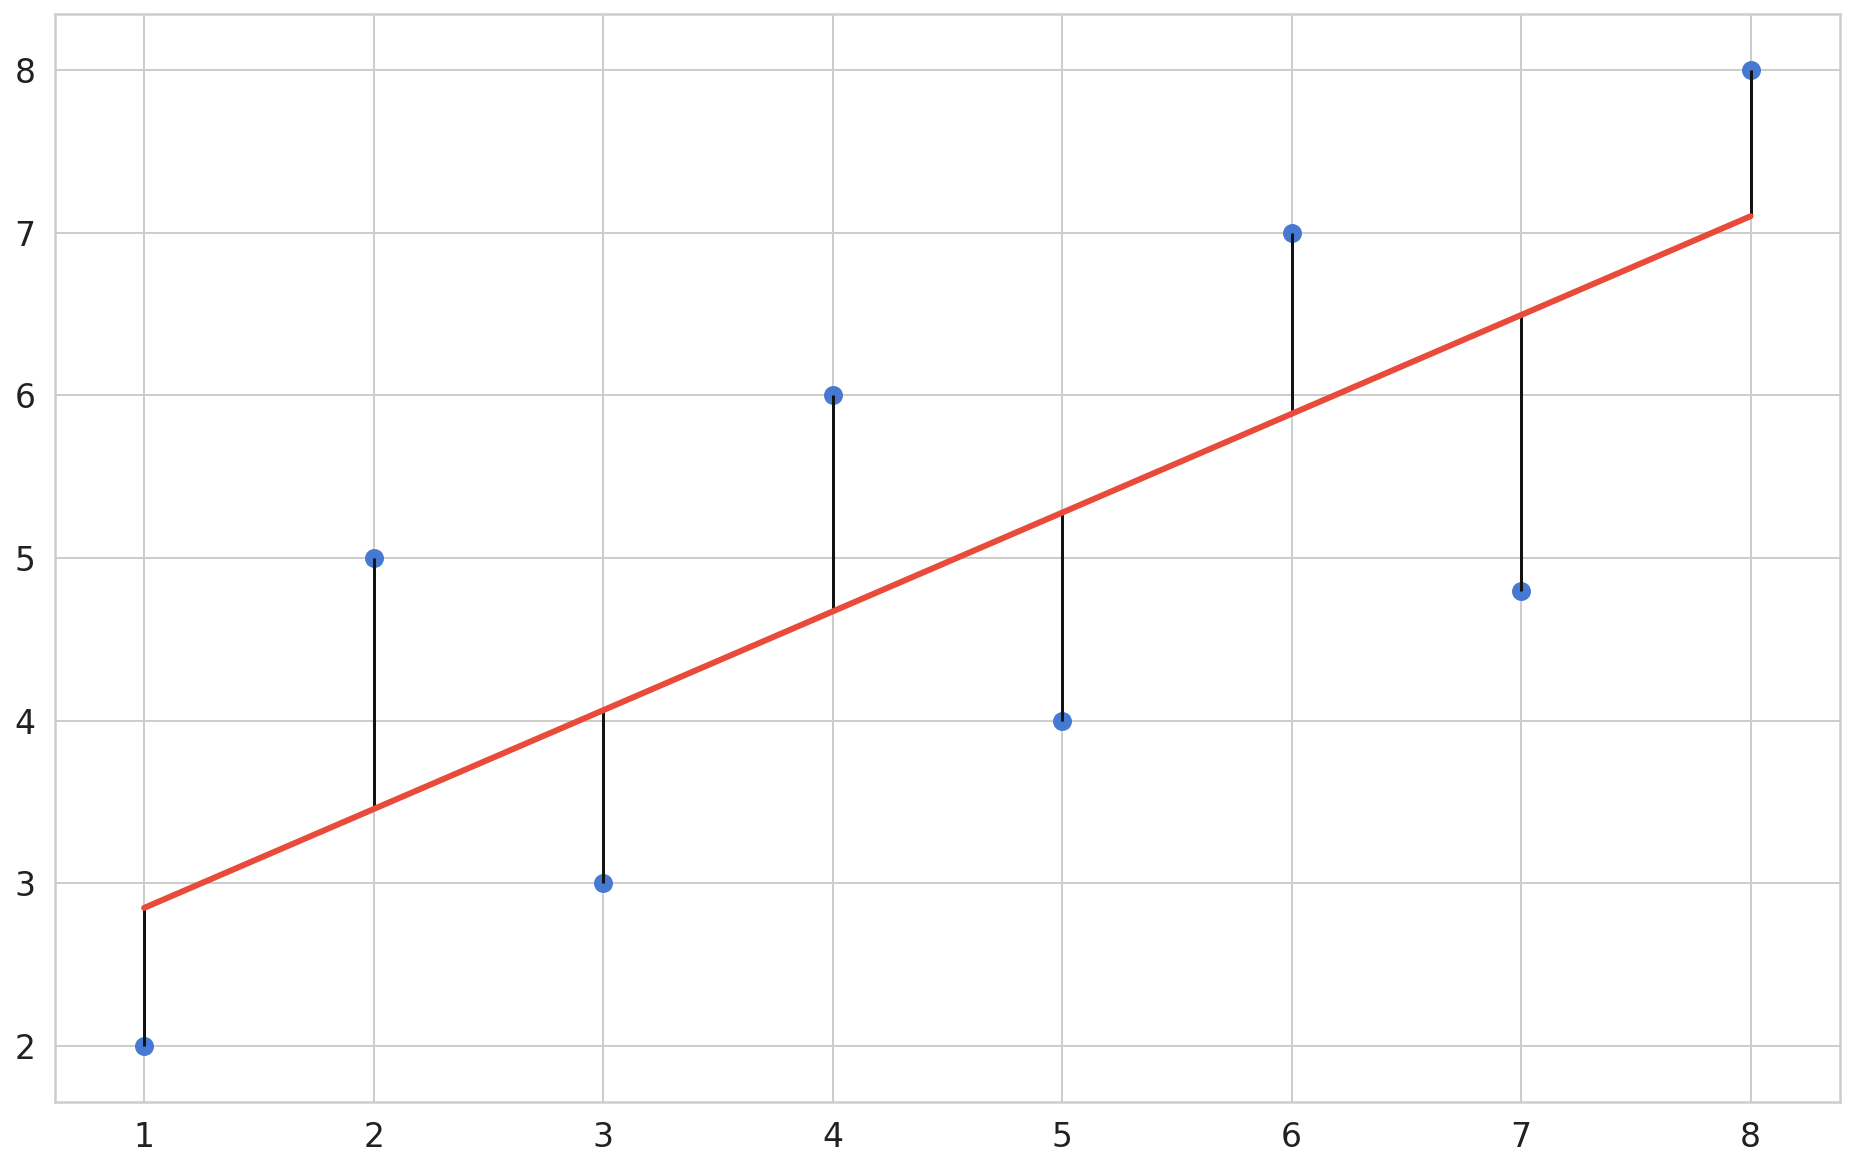